In [ ]:
"""
Exploratory Data Analysis (EDA) for Hard Hat / PPE Detection Dataset
====================================================================
Comprehensive analysis of the dataset including:
- Dataset statistics across train/val/test splits
- Class distribution and balance
- Image resolution analysis
- Bounding box size and aspect ratio analysis
- Visualizations
"""

from pathlib import Path
import os
import re
from collections import Counter, defaultdict
from typing import List, Tuple, Dict
import yaml

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Inline plots
%matplotlib inline
sns.set_style("whitegrid")

# ---- Configuration ----
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_YAML = DATA_DIR / "data.yaml"

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")

# Load dataset configuration
if DATA_YAML.exists():
    with open(DATA_YAML, 'r') as f:
        config = yaml.safe_load(f)
    class_names = config.get('names', ['head', 'helmet', 'person'])
    class_id_to_name = {i: name for i, name in enumerate(class_names)}
    print(f"Classes: {class_names}")
    print(f"Number of classes: {len(class_names)}")
else:
    print("⚠️  data.yaml not found!")
    class_names = ['head', 'helmet', 'person']
    class_id_to_name = {0: 'head', 1: 'helmet', 2: 'person'}


Project root: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project
Images dir:  c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\images
Labels dir:  c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\labels
Classes:     c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\classes.txt
Loaded 1 classes


In [ ]:
# Discover images and labels across all splits
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

splits = ['train', 'valid', 'test']
all_image_paths = []
all_label_paths = []
split_data = {}

for split in splits:
    split_dir = DATA_DIR / split
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    
    image_paths = []
    label_paths = []
    
    if images_dir.exists():
        for p in images_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in IMAGE_EXTS:
                image_paths.append(p)
                all_image_paths.append(p)
    
    if labels_dir.exists():
        for p in labels_dir.rglob("*.txt"):
            if p.is_file():
                label_paths.append(p)
                all_label_paths.append(p)
    
    split_data[split] = {
        'images': sorted(image_paths),
        'labels': sorted(label_paths)
    }

# Map image stem -> paths and label stem -> paths for each split
for split in splits:
    img_stem_to_path = {p.stem: p for p in split_data[split]['images']}
    lbl_stem_to_path = {p.stem: p for p in split_data[split]['labels']}
    
    images_with_labels = sorted(set(img_stem_to_path) & set(lbl_stem_to_path))
    images_without_labels = sorted(set(img_stem_to_path) - set(lbl_stem_to_path))
    labels_without_images = sorted(set(lbl_stem_to_path) - set(img_stem_to_path))
    
    split_data[split]['img_stem_to_path'] = img_stem_to_path
    split_data[split]['lbl_stem_to_path'] = lbl_stem_to_path
    split_data[split]['images_with_labels'] = images_with_labels
    split_data[split]['images_without_labels'] = images_without_labels
    split_data[split]['labels_without_images'] = labels_without_images

print(f"\n📊 Dataset Overview:")
print("=" * 70)
print(f"{'Split':<10} {'Images':<10} {'Labels':<10} {'Matched':<10} {'Missing Labels':<15} {'Missing Images':<15}")
print("-" * 70)
for split in splits:
    data = split_data[split]
    matched = len(data['images_with_labels'])
    missing_lbls = len(data['images_without_labels'])
    missing_imgs = len(data['labels_without_images'])
    print(f"{split:<10} {len(data['images']):<10} {len(data['labels']):<10} {matched:<10} {missing_lbls:<15} {missing_imgs:<15}")

total_images = len(all_image_paths)
total_labels = len(all_label_paths)
print("-" * 70)
print(f"{'TOTAL':<10} {total_images:<10} {total_labels:<10}")
print("=" * 70)


Found 184 images and 188 label files
Images with labels:  184
Images w/o labels:  0
Labels w/o images:  4
Sample image: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\images\002bf8b9-images152.jpg
Sample label: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\labels\002bf8b9-images152.txt


In [ ]:
# Parse YOLO labels and compute comprehensive stats

def parse_yolo_label_file(path: Path) -> List[Tuple[int, float, float, float, float]]:
    """Parse YOLO label file and return list of (class_id, x, y, w, h)."""
    rows: List[Tuple[int, float, float, float, float]] = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = re.split(r"\s+", line)
            if len(parts) < 5:
                continue
            try:
                cls = int(parts[0])
                x, y, w, h = map(float, parts[1:5])
                rows.append((cls, x, y, w, h))
            except Exception:
                continue
    return rows

# Compute stats across all splits
class_counts = Counter()
class_counts_by_split = {split: Counter() for split in splits}
images_box_counts: Dict[str, int] = {}
empty_label_files = []
invalid_label_files = []
boxes_records = []  # for DataFrame: image, split, cls, w, h, area, aspect

for split in splits:
    data = split_data[split]
    for stem in data['images_with_labels']:
        lbl_path = data['lbl_stem_to_path'][stem]
        try:
            rows = parse_yolo_label_file(lbl_path)
        except Exception:
            invalid_label_files.append(str(lbl_path))
            continue

        if len(rows) == 0:
            empty_label_files.append(str(lbl_path))

        images_box_counts[stem] = len(rows)
        for (cls, x, y, w, h) in rows:
            class_counts[cls] += 1
            class_counts_by_split[split][cls] += 1
            area = w * h
            aspect = (w / h) if h > 0 else np.nan
            boxes_records.append({
                "split": split,
                "image_stem": stem,
                "class_id": cls,
                "class_name": class_id_to_name.get(cls, str(cls)),
                "x": x, "y": y, "w": w, "h": h,
                "area": area,
                "aspect": aspect,
            })

print("\n📈 Class Distribution (Overall):")
print("=" * 50)
for cls_id, count in sorted(class_counts.items()):
    cls_name = class_id_to_name.get(cls_id, f"class_{cls_id}")
    pct = (count / sum(class_counts.values()) * 100) if class_counts else 0
    print(f"  {cls_name:10s} (ID {cls_id}): {count:6d} ({pct:5.1f}%)")

print(f"\n📊 Statistics:")
print(f"  Total boxes: {sum(class_counts.values())}")
print(f"  Empty label files: {len(empty_label_files)}")
print(f"  Invalid label files: {len(invalid_label_files)}")

boxes_df = pd.DataFrame(boxes_records)
print(f"\n✅ Created boxes DataFrame: {boxes_df.shape}")
print("\nFirst few records:")
display(boxes_df.head())


Boxes per class (top 10): [(0, 184)]
Empty label files: 0
Invalid label files: 0
boxes_df shape: (184, 9)


,image_stem,class_id,class_name,x,y,w,h,area,aspect
0,002bf8b9-images152,0,omar_car,0.523043,0.461825,0.906793,0.562384,0.509966,1.612411
1,006b7950-tb1tlaxK,0,omar_car,0.504035,0.567970,0.844196,0.677840,0.572230,1.245421
2,0170f809-images115,0,omar_car,0.503118,0.561453,0.924449,0.720670,0.666223,1.282763
3,0303e805-250x1883,0,omar_car,0.509114,0.486965,0.909579,0.884544,0.804563,1.028303
4,03a524bd-IMG_4416,0,omar_car,0.533830,0.577281,0.417132,0.204842,0.085446,2.036364


sizes_df shape: (184, 7)

Image size summary:
             width       height      aspect
count   184.000000   184.000000  184.000000
mean   1432.108696  1675.918478    1.198666
std    1182.711227  1693.921034    0.403485
min     183.000000   158.000000    0.665455
25%     279.000000   193.750000    0.750000
50%    1099.000000   666.500000    1.335052
75%    3024.000000  4032.000000    1.502732
max    3024.000000  4032.000000    2.012658


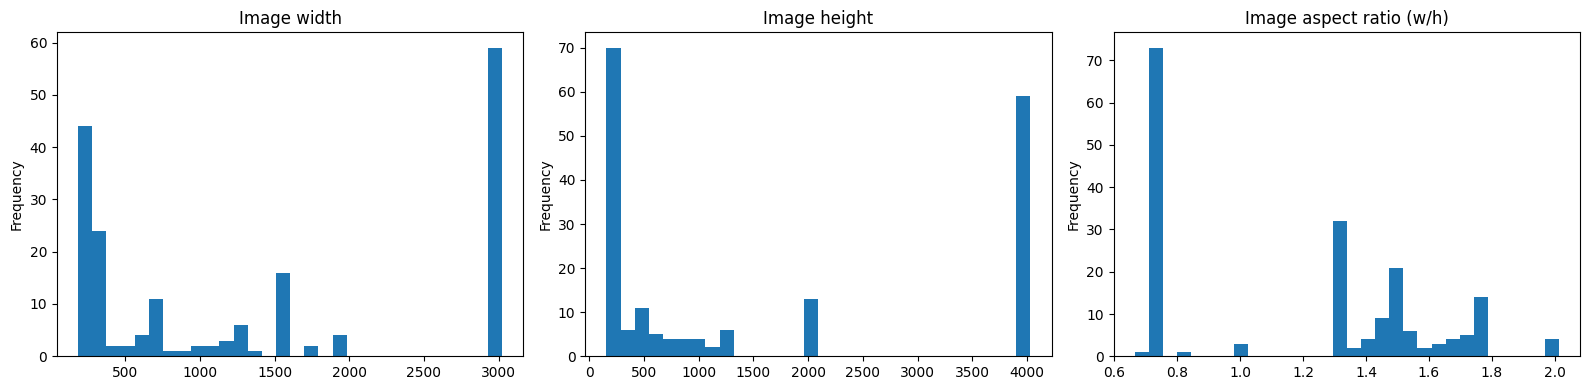


Top 10 image resolutions:
width  height
3024   4032      59
259    194       16
1536   2048      13
275    183       10
300    168        8
250    187        5
279    180        2
272    186        2
293    172        2
520    355        2
Name: count, dtype: int64


In [ ]:
# Image resolution and aspect ratio analysis across all splits

size_records = []
for split in splits:
    data = split_data[split]
    for p in data['images']:
        try:
            with Image.open(p) as im:
                w, h = im.size
        except Exception:
            w, h = None, None
        size_records.append({
            "split": split,
            "image_path": str(p),
            "stem": p.stem,
            "width": w,
            "height": h,
            "aspect": (w / h) if (w and h and h > 0) else np.nan,
            "has_label": p.stem in data['images_with_labels'],
            "num_boxes": images_box_counts.get(p.stem, 0),
        })

sizes_df = pd.DataFrame(size_records)
print("sizes_df shape:", sizes_df.shape)

print("\n📐 Image Size Summary (All Splits):")
print(sizes_df[["width", "height", "aspect"]].describe())

# Plot distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Overall distributions
sizes_df["width"].dropna().plot(kind="hist", bins=50, ax=axes[0, 0], title="Image Width Distribution", color='skyblue')
axes[0, 0].set_xlabel("Width (pixels)")
axes[0, 0].set_ylabel("Frequency")

sizes_df["height"].dropna().plot(kind="hist", bins=50, ax=axes[0, 1], title="Image Height Distribution", color='lightcoral')
axes[0, 1].set_xlabel("Height (pixels)")
axes[0, 1].set_ylabel("Frequency")

sizes_df["aspect"].dropna().plot(kind="hist", bins=50, ax=axes[0, 2], title="Aspect Ratio Distribution (w/h)", color='lightgreen')
axes[0, 2].set_xlabel("Aspect Ratio")
axes[0, 2].set_ylabel("Frequency")

# By split
for idx, split in enumerate(splits):
    split_sizes = sizes_df[sizes_df['split'] == split]
    if len(split_sizes) > 0:
        split_sizes["width"].dropna().plot(kind="hist", bins=30, ax=axes[1, idx], 
                                           title=f"{split.upper()} - Width Distribution", alpha=0.7)
        axes[1, idx].set_xlabel("Width (pixels)")

plt.tight_layout()
plt.show()

# Common resolutions
print("\n📏 Top 10 Image Resolutions:")
common_sizes = sizes_df.value_counts(subset=["width", "height"]).head(10)
print(common_sizes)


Class distribution:


,class_id,class_name,count
0,0,omar_car,184


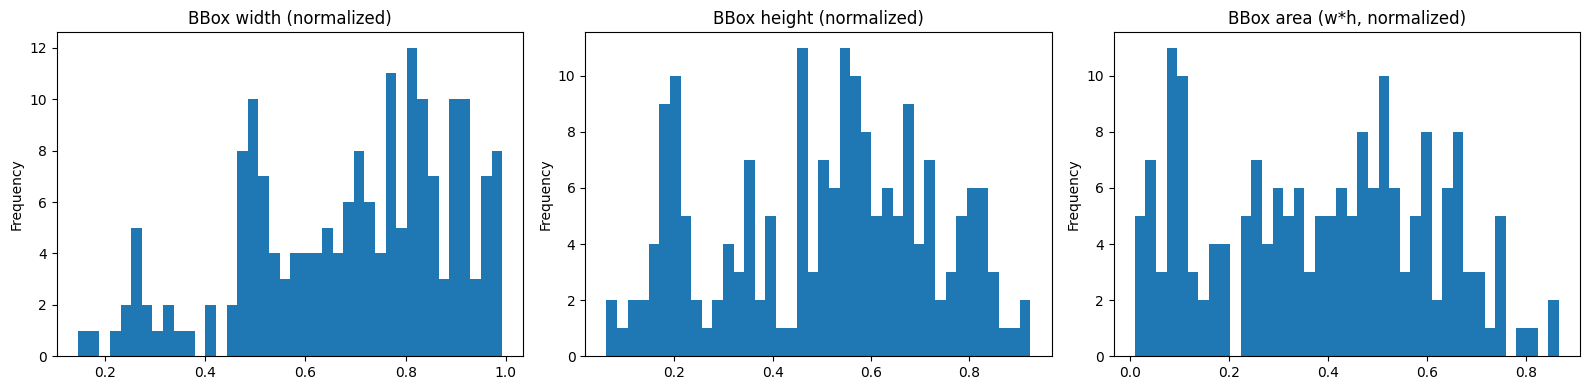


BBox size buckets:
size_bucket
large     143
medium     39
small       2
Name: count, dtype: int64


In [ ]:
# Class distribution and bbox size analysis

if len(boxes_df) > 0:
    # Class distribution by split
    print("\n📊 Class Distribution by Split:")
    cls_by_split = boxes_df.groupby(["split", "class_name"]).size().unstack(fill_value=0)
    display(cls_by_split)
    
    # Visualize class distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Overall class distribution
    cls_counts = boxes_df["class_name"].value_counts()
    cls_counts.plot(kind="bar", ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0].set_title("Overall Class Distribution", fontsize=14, fontweight='bold')
    axes[0].set_xlabel("Class", fontsize=12)
    axes[0].set_ylabel("Count", fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Class distribution by split
    cls_by_split.plot(kind="bar", ax=axes[1], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1].set_title("Class Distribution by Split", fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Split", fontsize=12)
    axes[1].set_ylabel("Count", fontsize=12)
    axes[1].legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

    # Bounding box size analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Width, height, area distributions
    boxes_df["w"].plot(kind="hist", bins=50, ax=axes[0, 0], title="BBox Width (normalized)", color='skyblue', alpha=0.7)
    axes[0, 0].set_xlabel("Normalized Width")
    axes[0, 0].set_ylabel("Frequency")
    
    boxes_df["h"].plot(kind="hist", bins=50, ax=axes[0, 1], title="BBox Height (normalized)", color='lightcoral', alpha=0.7)
    axes[0, 1].set_xlabel("Normalized Height")
    axes[0, 1].set_ylabel("Frequency")
    
    boxes_df["area"].plot(kind="hist", bins=50, ax=axes[0, 2], title="BBox Area (normalized)", color='lightgreen', alpha=0.7)
    axes[0, 2].set_xlabel("Normalized Area (w*h)")
    axes[0, 2].set_ylabel("Frequency")
    
    # Aspect ratio by class
    for idx, cls_name in enumerate(class_names):
        cls_boxes = boxes_df[boxes_df['class_name'] == cls_name]
        if len(cls_boxes) > 0:
            cls_boxes["aspect"].plot(kind="hist", bins=30, ax=axes[1, idx], 
                                     title=f"{cls_name.upper()} - Aspect Ratio", alpha=0.7)
            axes[1, idx].set_xlabel("Aspect Ratio (w/h)")
            axes[1, idx].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

    # Small/medium/large by area thresholds
    def area_bucket(a: float) -> str:
        if a < 0.02:
            return "small"
        if a < 0.15:
            return "medium"
        return "large"

    boxes_df["size_bucket"] = boxes_df["area"].apply(area_bucket)
    print("\n📦 BBox Size Buckets:")
    print(boxes_df["size_bucket"].value_counts())
    
    # Size buckets by class
    print("\n📦 Size Buckets by Class:")
    size_by_class = pd.crosstab(boxes_df["class_name"], boxes_df["size_bucket"])
    display(size_by_class)
else:
    print("No boxes found to analyze.")


TypeError: 'list' object cannot be interpreted as an integer

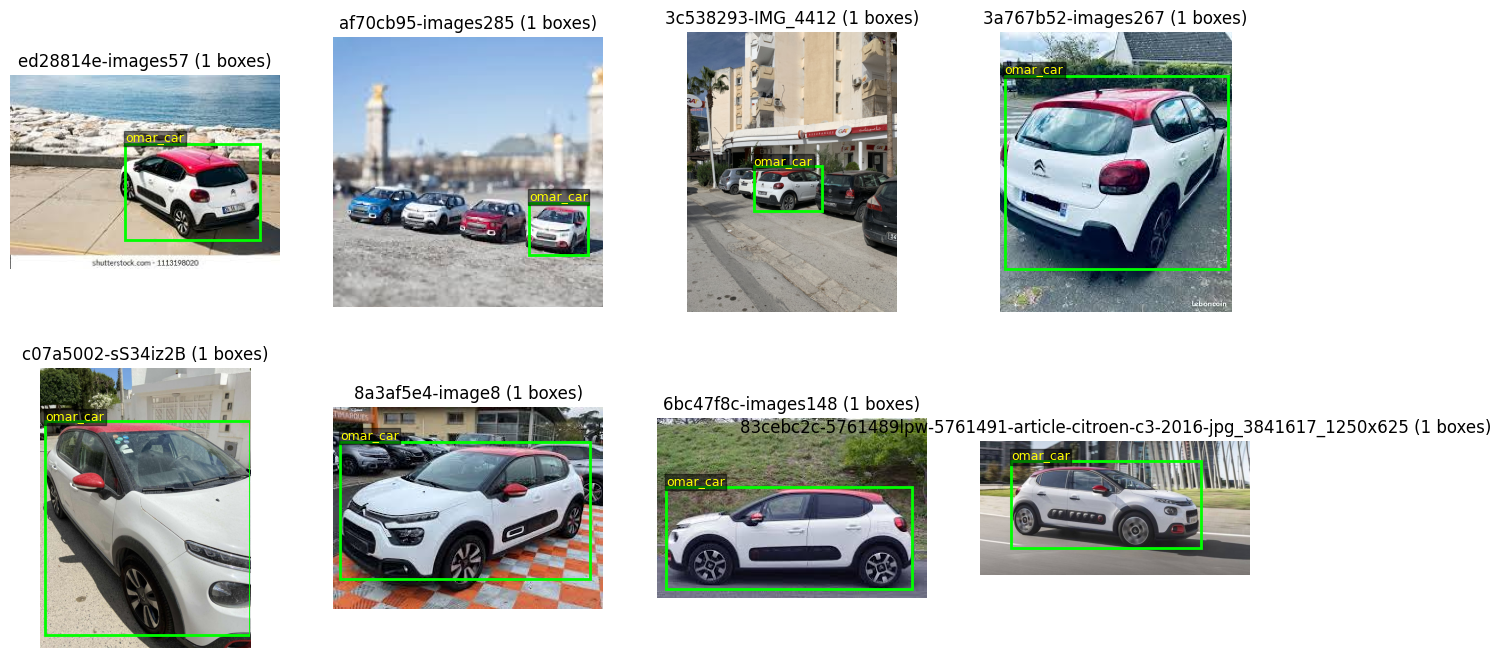

In [ ]:
# Visualize random samples with YOLO boxes from each split
import random
import math

def yolo_to_xyxy(x: float, y: float, w: float, h: float, img_w: int, img_h: int) -> Tuple[int, int, int, int]:
    """Convert YOLO format to xyxy coordinates."""
    cx = x * img_w
    cy = y * img_h
    bw = w * img_w
    bh = h * img_h
    x1 = int(max(0, cx - bw / 2))
    y1 = int(max(0, cy - bh / 2))
    x2 = int(min(img_w - 1, cx + bw / 2))
    y2 = int(min(img_h - 1, cy + bh / 2))
    return x1, y1, x2, y2

# Color mapping for classes
class_colors = {
    'head': 'red',
    'helmet': 'lime',
    'person': 'cyan'
}

# Visualize samples from each split
num_samples_per_split = 2
total_samples = num_samples_per_split * len(splits)
cols = 4
rows = math.ceil(total_samples / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
if rows * cols == 1:
    axes = np.array([[axes]])
elif rows == 1:
    axes = np.array([axes])
else:
    axes = axes.flatten()

idx = 0
for split in splits:
    data = split_data[split]
    available_stems = data['images_with_labels']
    if len(available_stems) == 0:
        continue
    
    num_samples = min(num_samples_per_split, len(available_stems))
    sample_stems = random.sample(available_stems, num_samples)
    
    for stem in sample_stems:
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        img_path = data['img_stem_to_path'][stem]
        lbl_path = data['lbl_stem_to_path'][stem]

        with Image.open(img_path) as im:
            im_rgb = im.convert("RGB")
            img_w, img_h = im_rgb.size
            ax.imshow(im_rgb)

        label_rows = parse_yolo_label_file(lbl_path)
        for (cls, x, y, w, h) in label_rows:
            x1, y1, x2, y2 = yolo_to_xyxy(x, y, w, h, img_w, img_h)
            cls_name = class_id_to_name.get(cls, str(cls))
            color = class_colors.get(cls_name, 'yellow')
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, 
                               edgecolor=color, linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1 - 2, cls_name, color='white', fontsize=9, 
                   bbox=dict(facecolor=color, alpha=0.7, pad=2))

        ax.set_title(f"{split.upper()}: {stem[:30]}... ({len(label_rows)} boxes)", fontsize=10)
        ax.axis('off')
        idx += 1

# Hide unused subplots
for j in range(idx, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Comprehensive dataset summary
print("\n" + "=" * 70)
print("COMPREHENSIVE DATASET SUMMARY - Hard Hat / PPE Detection")
print("=" * 70)

num_images = total_images
num_labels = total_labels
num_boxes_total = int(boxes_df.shape[0]) if 'boxes_df' in globals() and len(boxes_df) > 0 else 0

print(f"\n📊 Overall Statistics:")
print(f"  Total images:              {num_images}")
print(f"  Total label files:          {num_labels}")
print(f"  Empty label files:          {len(empty_label_files)}")
print(f"  Invalid/corrupt labels:     {len(invalid_label_files)}")
print(f"  Total bounding boxes:       {num_boxes_total}")

print(f"\n📈 Split Distribution:")
for split in splits:
    data = split_data[split]
    matched = len(data['images_with_labels'])
    pct = (matched / num_images * 100) if num_images > 0 else 0
    print(f"  {split.upper():10s}: {len(data['images']):5d} images ({pct:5.1f}%)")

if len(boxes_df) > 0:
    print(f"\n📦 Class Distribution:")
    by_class = boxes_df.groupby('class_name').size().sort_values(ascending=False)
    for cls_name, count in by_class.items():
        pct = (count / num_boxes_total * 100) if num_boxes_total > 0 else 0
        print(f"  {cls_name:10s}: {count:6d} boxes ({pct:5.1f}%)")
    
    print(f"\n📏 Bounding Box Statistics:")
    print(f"  Mean width (normalized):  {boxes_df['w'].mean():.4f}")
    print(f"  Mean height (normalized): {boxes_df['h'].mean():.4f}")
    print(f"  Mean area (normalized):   {boxes_df['area'].mean():.4f}")
    print(f"  Mean aspect ratio:        {boxes_df['aspect'].mean():.4f}")

print(f"\n📐 Image Statistics:")
if len(sizes_df) > 0:
    print(f"  Mean width:               {sizes_df['width'].mean():.0f} px")
    print(f"  Mean height:              {sizes_df['height'].mean():.0f} px")
    print(f"  Mean aspect ratio:        {sizes_df['aspect'].mean():.4f}")

print("\n" + "=" * 70)
print("✅ EDA Complete - Dataset is ready for training!")
print("=" * 70)
print("\n💡 Recommendations:")
print("  - Review class balance; consider data augmentation if imbalanced")
print("  - Check bbox size distribution; adjust input size if many small boxes")
print("  - Verify train/val/test splits are appropriate")
print("  - Consider augmentation strategies based on image diversity")


==== DATASET SUMMARY ====
Images:                   125
Label files:              129
Images with labels:       125
Images without labels:    0
Labels without images:    4
Empty label files:        0
Invalid/corrupt labels:   0
Total boxes:              125

Boxes per class:
class_name
omar_car    125
dtype: int64

Notes:
- Ensure all images have matching label files if expected.
- Check class balance and consider collecting more samples if skewed.
- Review bbox size distribution; many small boxes may benefit from higher input size.
